<a target="_blank" href="https://colab.research.google.com/github/cerr/pyCERR-Notebooks/blob/main/image_filters_lung_ct.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# IBSI-2 compatible image texture using pyCERR


This notebook demonstrates how to apply IBSI-2 compatible image filters using pyCERR.

Supported filters include: *Mean*, *Sobel*, *Laplacian of Gaussian (LoG)*, *Laws'/Laws' Energy*, and *Gabor*.  
All filters are implemented as per the [IBSI2](https://theibsi.github.io/ibsi2/) standard, including support for 3D approximations and rotation invariance where defined.

## Install pyCERR (dev version)

In [1]:
%%capture
! pip install "pyCERR[napari] @ git+https://github.com/cerr/pyCERR"

## Download settings

In [2]:
%%capture
import os
from cerr import datasets
datasetsDir = os.path.dirname(datasets.__file__)
settingsFile = os.path.join(datasetsDir,"convolutional_filter_settings","LoG_filter.json")


In [3]:
! pip install jsbeautifier

## Read sample DICOM images

* The dataset used here, comprising a Lung CT scan with tumor segmentation, was made available by Lambin et al. via CancerData and is included with pyCERR.

* Selected filter parameters used in compatibilty tests with the IBSI-2 standard are used in this demonstration.

In [4]:
import os, numpy as np
from cerr import datasets, plan_container as pc

# Path to DICOM data
sampleDataPath = os.path.dirname(datasets.__file__)
sampleDataDir = os.path.join(sampleDataPath, 'radiomics_phantom_dicom', 'pat_1')

# Import contents to planC
planC = pc.loadDcmDir(sampleDataDir)

('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.258301620411152643708006163321128526885', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT', 'RTSTRUCT')
('PAT1', 'PAT1', '1.3.6.1.4.1.9590.100.1.2.96328687310426543129572151154132284399', '1.3.6.1.4.1.9590.100.1.2.296658988911737913102339329841519593982', 'CT', 'CT', 'CT', 'CT', 'CT', 'CT', 'CT')


## Apply IBSI2 filters

*Note*:
* Sample filter settings can be downloaded from [https://github.com/cerr/pyCERR-Notebooks](https://github.com/cerr/pyCERR-Notebooks/settings/). The `settingsDir` variable below should point to directory containing settings files.
* The examples below use the *Napari* package for visualization. *Napari* requires a display for rendering graphics and does not support interactive visualization on a remote server (e.g. Google Colab).

### Review filter settings

In [5]:
import json, jsbeautifier
from cerr.radiomics import texture_utils

options = jsbeautifier.default_options()
options.indent_size = 4

# Path to JSON settings file with filter parameters
paramS, __ = texture_utils.loadSettingsFromFile(settingsFile)

# Display settings
print(jsbeautifier.beautify(json.dumps(paramS), options))

# Compute filter response
scanNum = 0
strNum = 0
planC = texture_utils.generateTextureMapFromPlanC(planC, scanNum, strNum, settingsFile)
filtIdx = len(planC.scan)-1         # Index of filtered scan


{
    "structures": ["GTV"],
    "imageType": {
        "LoG": {
            "Sigma_mm": [1.5, 1.5, 1.5],
            "CutOff_mm": [4.5, 4.5, 4.5]
        }
    },
    "settings": {
        "cropToMask": {
            "method": "expand",
            "size": [6, 6, 6]
        }
    }
}


### Copy Structure from CT to filtered image

In [6]:
import cerr.dataclasses.structure as cerrStr
structNum = 0
filteredScanNum = 1
planC = cerrStr.copyToScan(0, 1, planC)

## Capture screenshot

In [7]:
!export NAPARI_APPLICATION_IPY_INTERACTIVE=0
!export QT_DEBUG_PLUGINS=1 > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install libqt5x11extras5-dev > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
from pyvirtualdisplay import Display
virtualDisplay = Display(backend="xvfb", size=(600, 600))
virtualDisplay.start()

saved to filtered_img.png


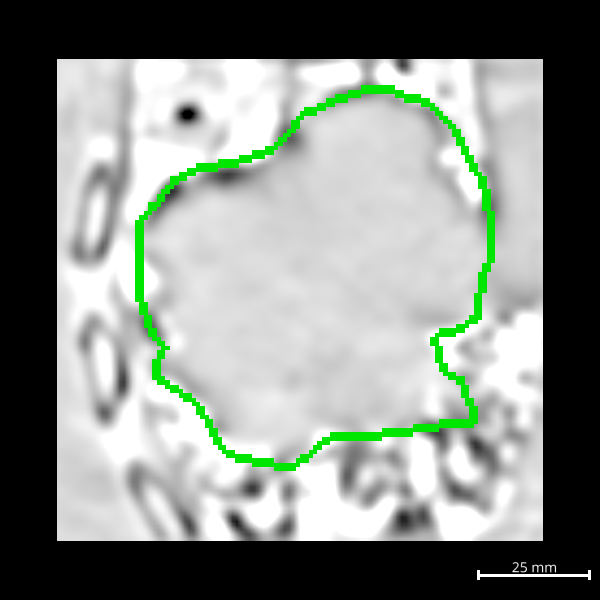

In [8]:
from IPython.display import Image, display
from cerr import plan_container as pc
import cerr.contour.rasterseg as rs
from cerr import viewer as vwr
from skimage.io import imsave, imshow
import numpy as np
import os

capture_fname = 'filtered_img.png'
dispScanNum = [filtIdx]
dispStrNum = [len(planC.structure)-1]
dispDoseNum = []
vectorDict = {}
viewer, scan_layer, struct_layer, dose_layer, dvf_layer = \
    vwr.showNapari(planC, scan_nums=dispScanNum, struct_nums=dispStrNum, dose_nums=dispDoseNum, vectors_dict={}, displayMode='2d')

scan_layer[0].opacity = 1
scan_layer[0].contrast_limits_range = [-800, 200]
scan_layer[0].contrast_limits = [-800, 200]
scan_layer[0].gamma = 0.7

screenshot = viewer.screenshot(size =(600, 600))
viewer.close()
imsave(capture_fname, screenshot)
print('saved to '+ capture_fname)
display(Image(filename=capture_fname, retina=False, width=200, embed=True))

In [9]:
scan3M = planC.scan[-1].getScanArray()
print(planC.scan[-1].scanInfo[0].imageType)
print(scan3M.min())
print(scan3M.max())

LoG
-1604.2773334470467
1855.8202701362156


In [11]:
from cerr import viewer as vwr
scanNum = [0,1]
doseNum = []
strNum = 0
vectorDict = {}
viewer, scan_layer, struct_layer, dose_layer, dvf_layer = \
    vwr.showNapari(planC, scan_nums=scanNum, struct_nums=strNum, dose_nums=doseNum, vectors_dict={}, displayMode='2d')
